NISP, ICML, ICLR, ECML

In [ ]:
cd /content/drive/MyDrive/Vin/Mask_RCNN

/content/drive/MyDrive/Vin/Mask_RCNN


In [ ]:
!pip install tensorflow==1.5.0
!pip install tensorflow-gpu==1.15.0
# !pip install keras==2.0.8

!pip install keras==2.1.5

In [8]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
ROOT_DIR = os.path.abspath("../")
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "city_small"
    BACKBONE = "resnet50"
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 10

    # Number of classes (including background)
    NUM_CLASSES = 1 + 21 # background + 21 class

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 50

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 50
    

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     10
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 10
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                34
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
import json
import skimage
from tqdm import tqdm
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the custom dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train, test or val
        """
        self.add_class("city_small", 1, "road")
        self.add_class("city_small", 2, "sidewalk")
        self.add_class("city_small", 3, "building")
        self.add_class("city_small", 4, "wall")
        self.add_class("city_small", 5, "fence")
        self.add_class("city_small", 6, "guard rail")
        self.add_class("city_small", 7, "bridge")
        self.add_class("city_small", 8, "tunnel")
        self.add_class("city_small", 9, "pole")
        self.add_class("city_small", 10, "polegroup")
        self.add_class("city_small", 11, "traffic light")
        self.add_class("city_small", 12, "traffic sign")
        self.add_class("city_small", 13, "person")
        self.add_class("city_small", 14, "rider")
        self.add_class("city_small", 15, "car")
        self.add_class("city_small", 16, "truck")
        self.add_class("city_small", 17, "bus")
        self.add_class("city_small",18,"caravan")
        self.add_class("city_small", 19, "train")
        self.add_class("city_small",20,"motorcycle")
        self.add_class("city_small",21, "bicycle")



        assert subset in ["train", "val", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print(f'Load {subset} from {dataset_dir}')

        annotations = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        annotations = list(annotations.values())

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in tqdm(annotations):
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #labelling each class in the given image to a number

            custom = [s['region_attributes'] for s in a['regions'].values()]
            
            num_ids=[]
            #Add the classes according to the requirement
            for n in custom:
              try:
                if n['label']=='road':
                  num_ids.append(1)
                elif n['label']=='sidewalk':
                  num_ids.append(2)
                elif n['label']=='building':
                  num_ids.append(3)
                elif n['label']=='wall':
                  num_ids.append(4)
                elif n['label']=='fence':
                  num_ids.append(5)
                elif n['label']=='guard rail':
                  num_ids.append(6)
                elif n['label']=='bridge':
                  num_ids.append(7)
                elif n['label']=='tunnel':
                  num_ids.append(8)
                elif n['label']=='pole':
                  num_ids.append(9)
                elif n['label']=='polegroup':
                  num_ids.append(10)
                elif n['label']=='traffic light':
                  num_ids.append(11)
                elif n['label']=='traffic sign':
                  num_ids.append(12)
                elif n['label']=='person':
                  num_ids.append(13)
                elif n['label']=='rider':
                  num_ids.append(14)
                elif n['label']=='car':
                  num_ids.append(15)
                elif n['label']=='truck':
                  num_ids.append(16)
                elif n['label']=='bus':
                  num_ids.append(17)
                elif n['label']=='caravan':
                  num_ids.append(18)
                elif n['label']=='train':
                  num_ids.append(19)
                elif n['label']=='motorcycle':
                  num_ids.append(20)
                elif n['label']=='bicycle':
                  num_ids.append(21)
              except:
                  pass

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "city_small",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a custom dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "city_small":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = image_info['num_ids']	
        #print("Here is the numID",num_ids)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)	
        return mask, num_ids#.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32), 

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "city_small":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:

# # Training dataset,

# dataset_train = CustomDataset()
# dataset_train.load_custom('../../small_datasets', 'train')
# dataset_train.prepare()
# with open('../../logs/pickle/data_train.pickle', 'wb') as f:
#   pickle.dump(dataset_train, f)
# # Validation dataset
# dataset_val = CustomDataset()
# dataset_val.load_custom('../../small_datasets', 'val')
# dataset_val.prepare()
# with open('../../logs/pickle/data_val.pickle', 'wb') as f:
#   pickle.dump(dataset_val, f)
# # Validation dataset
# dataset_test = CustomDataset()
# dataset_test.load_custom('../../small_datasets', 'test')
# dataset_test.prepare()
# with open('../../logs/pickle/data_test.pickle', 'wb') as f:
#   pickle.dump(dataset_test, f)
with open('../../logs/pickle/data_train.pickle', 'rb') as f:
  dataset_train = pickle.load(f)
with open('../../logs/pickle/data_val.pickle', 'rb') as f:
  dataset_val = pickle.load(f)
with open('../../logs/pickle/data_test.pickle', 'rb') as f:
  dataset_test = pickle.load(f)

Load train from /content/drive/MyDrive/Vin/small_datasets/train


 37%|███▋      | 37/100 [00:00<00:00, 365.18it/s]

Load val from /content/drive/MyDrive/Vin/small_datasets/val


  0%|          | 0/100 [00:00<?, ?it/s]

Load test from /content/drive/MyDrive/Vin/small_datasets/test


100%|██████████| 100/100 [00:00<00:00, 371.78it/s]


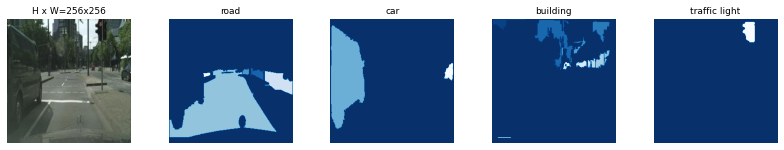

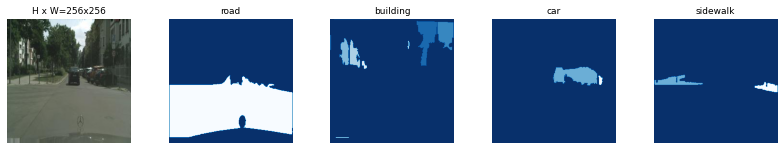

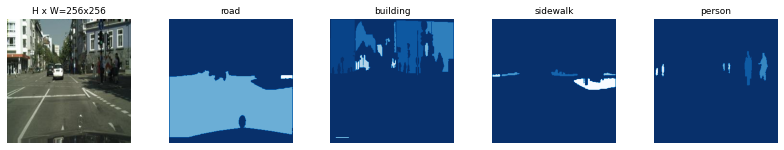

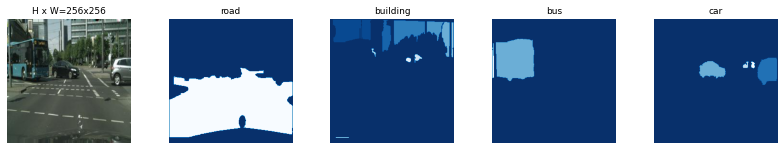

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

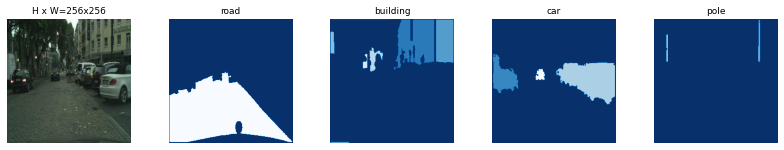

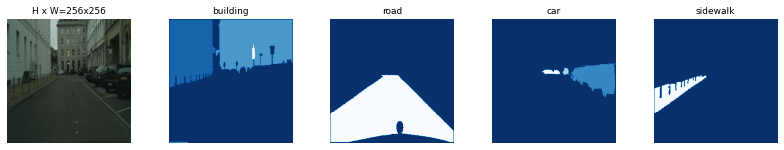

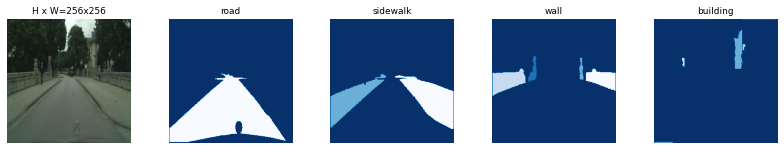

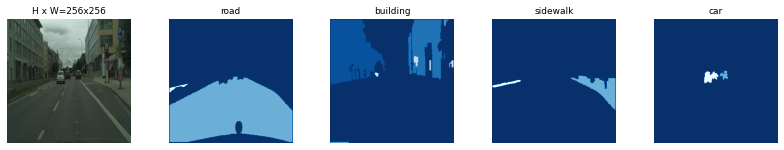

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

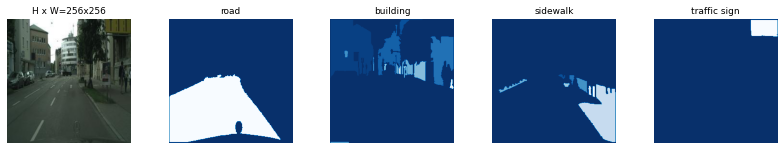

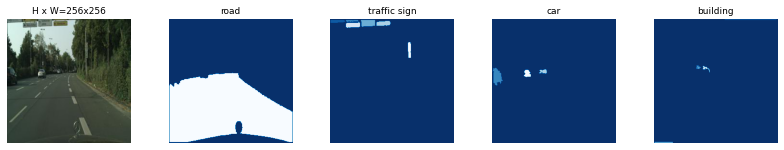

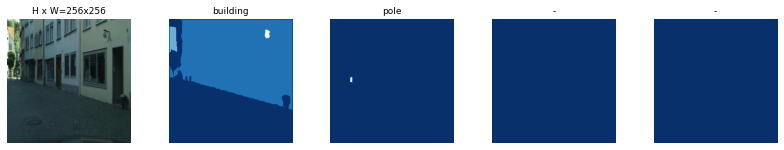

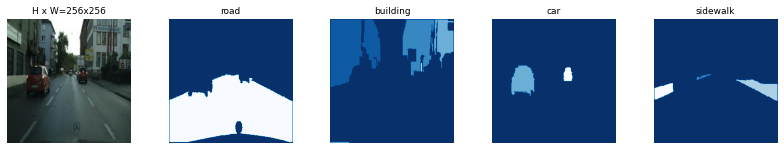

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_test.image_ids, 4)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

In [ ]:
# Create model in training mode
from mrcnn import utils
import mrcnn.model as modellib
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 429


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1000, 
            layers='heads')


Starting at epoch 352. LR=0.001

Checkpoint Path: /content/drive/My Drive/logs/city_small20210114T0842/mask_rcnn_city_small_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 353/1000
49/50 [============================>.] - ETA: 1s - loss: 1.1331 - rpn_class_loss: 0.1296 - rpn_bbox_loss: 0.4405 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.3360

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


50/50 [==============================] - 125s 2s/step - loss: 1.1352 - rpn_class_loss: 0.1302 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.1288 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.3365 - val_loss: 4.1329 - val_rpn_class_loss: 0.2577 - val_rpn_bbox_loss: 1.8807 - val_mrcnn_class_loss: 0.9485 - val_mrcnn_bbox_loss: 0.5791 - val_mrcnn_mask_loss: 0.4669

Epoch 354/1000
50/50 [==============================] - 65s 1s/step - loss: 1.1256 - rpn_class_loss: 0.1289 - rpn_bbox_loss: 0.4351 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.3340 - val_loss: 4.0145 - val_rpn_class_loss: 0.2527 - val_rpn_bbox_loss: 1.8378 - val_mrcnn_class_loss: 0.9377 - val_mrcnn_bbox_loss: 0.5449 - val_mrcnn_mask_loss: 0.4415
Epoch 355/1000
50/50 [==============================] - 68s 1s/step - loss: 1.1274 - rpn_class_loss: 0.1291 - rpn_bbox_loss: 0.4327 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.3318 - val_loss: 3.9117 - val_rpn_class_loss: 0.231

KeyboardInterrupt: ignored

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1000, 
            layers='heads')